In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest

# Set a default seaborn style for consistency
sns.set(style="whitegrid")

In [8]:
def load_data(file_path: str) -> pd.DataFrame:
    """
    Load the dataset from a single CSV file.
    """
    df = pd.read_csv(file_path)
    return df

def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess the dataframe by converting date columns,
    extracting day names and hour, encoding day_of_week, and calculating age.
    """
    # Chuyển đổi cột trans_date_trans_time sang datetime và trích xuất thông tin
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['day_of_week'] = df['trans_date_trans_time'].dt.day_name()
    df['hour'] = df['trans_date_trans_time'].dt.hour

    # Mã hóa day_of_week: ánh xạ thứ trong tuần sang số (Monday=1, ..., Sunday=7)
    day_mapping = {
        'Monday': 1,
        'Tuesday': 2,
        'Wednesday': 3,
        'Thursday': 4,
        'Friday': 5,
        'Saturday': 6,
        'Sunday': 7
    }
    df['day_of_week'] = df['day_of_week'].map(day_mapping)
    
    # Tính tuổi theo năm 2025 (có thể điều chỉnh nếu cần)
    df['age'] = 2025 - pd.to_datetime(df['dob']).dt.year

    # Lưu dữ liệu đã tiền xử lý vào file CSV
    df.to_csv("/home/ducanh/Financial Risk & Fraud Detection/Credit Card Fraud Detection/Datasets/CCFD/Combined_Data/combined_data.csv", index=False)
    return df


def dataset_summary(df: pd.DataFrame) -> None:
    """
    Print the total number of transactions and unique credit card numbers.
    """
    total_transactions = df.shape[0]
    unique_cc_nums = df['cc_num'].nunique()
    rate = total_transactions / unique_cc_nums 
    
    print("Total number of transactions:", total_transactions)
    print("Total number of unique credit card numbers:", unique_cc_nums)
    print("Rate (total transactions / unique credit card numbers):", rate)
    
def transaction_analysis(df: pd.DataFrame) -> None:
    """
    Analyze the number of transactions per credit card.
    """
    # Group by credit card number and count transactions
    trans_count = df.groupby('cc_num').size()
    
    # Also print the maximum and minimum transaction counts
    max_trans = trans_count.max()
    min_trans = trans_count.min()
    max_cc = trans_count.idxmax()
    min_cc = trans_count.idxmin()
    print("Max transactions:", max_trans, "for cc_num:", max_cc)
    print("Min transactions:", min_trans, "for cc_num:", min_cc)

def transaction_analysis_histogram(df: pd.DataFrame) -> None:
    """
    Plot a histogram showing the distribution of transaction counts per credit card.
    """
    
    # Group by credit card number and count transactions
    trans_count = df.groupby('cc_num').size()
    
    # Plot a histogram of the transaction counts
    plt.figure(figsize=(10, 6))
    sns.histplot(trans_count, bins=50, kde=False)  # Adjust bins as needed
    plt.xlabel("Number of Transactions (per credit card)")
    plt.ylabel("Count of Credit Cards")
    plt.title("Distribution of Transactions per Credit Card")
    plt.tight_layout()
    plt.show()

    # Print basic stats
    print(f"Mean transactions per card: {trans_count.mean():.2f}")
    print(f"Median transactions per card: {trans_count.median():.2f}")
    print(f"Max transactions: {trans_count.max()}")
    print(f"Min transactions: {trans_count.min()}")

def transaction_analysis_top_n(df: pd.DataFrame, top_n=20) -> None:
    """
    Plot a bar chart for the top N credit cards by number of transactions.
    """

    
    # Group by credit card number and count transactions
    trans_count = df.groupby('cc_num').size().sort_values(ascending=False)
    
    # Select the top N
    top_trans_count = trans_count.head(top_n)
    
    # Plot the top N
    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_trans_count.index.astype(str), y=top_trans_count.values, palette="viridis")
    plt.xlabel("Credit Card Number (cc_num)")
    plt.ylabel("Number of Transactions")
    plt.title(f"Top {top_n} Credit Cards by Number of Transactions")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Print basic stats for these top N
    print(f"Max transactions (within top {top_n}): {top_trans_count.max()}")
    print(f"Min transactions (within top {top_n}): {top_trans_count.min()}")

def transaction_analysis_boxplot(df: pd.DataFrame) -> None:
    """
    Create a box plot showing the distribution of transaction counts per credit card.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    trans_count = df.groupby('cc_num').size()
    
    plt.figure(figsize=(6, 6))
    sns.boxplot(y=trans_count.values, color="skyblue")
    plt.ylabel("Number of Transactions")
    plt.title("Box Plot of Transactions per Credit Card")
    plt.tight_layout()
    plt.show()

def fraud_analysis(df: pd.DataFrame) -> None:
    """
    Analyze fraudulent transactions by day of week and hour,
    and calculate fraud-related percentages.
    """
    fraud_df = df[df['is_fraud'] == 1]
    
    # Analyze fraud by day (ensuring proper weekday order)
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    fraud_day_count = fraud_df['day_of_week'].value_counts().reindex(days_order)
    
    # Analyze fraud by hour
    fraud_hour_count = fraud_df['hour'].value_counts().sort_index()
    
    print("Fraud transactions by day:\n", fraud_day_count)
    print("\nFraud transactions by hour:\n", fraud_hour_count)
    
    # Plot fraud transactions by day
    plt.figure(figsize=(10, 4))
    sns.barplot(x=fraud_day_count.index, y=fraud_day_count.values, palette="viridis")
    plt.title('Fraud Transactions by Day of Week')
    plt.xlabel('Day of Week')
    plt.ylabel('Number of Fraud Transactions')
    plt.tight_layout()
    plt.show()
    
    # Plot fraud transactions by hour
    plt.figure(figsize=(10, 4))
    sns.barplot(x=fraud_hour_count.index, y=fraud_hour_count.values, palette="magma")
    plt.title('Fraud Transactions by Hour')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Fraud Transactions')
    plt.tight_layout()
    plt.show()
    
    # Calculate and print fraud percentages
    fraudulent_cc = fraud_df['cc_num'].nunique()
    total_cc = df['cc_num'].nunique()
    fraud_cc_percent = (fraudulent_cc / total_cc) * 100
    
    fraud_transactions = fraud_df.shape[0]
    total_transactions = df.shape[0]
    fraud_transactions_percent = (fraud_transactions / total_transactions) * 100
    
    print("Unique cc_num with fraud transactions: {} ({:.2f}% of all cc_num)".format(fraudulent_cc, fraud_cc_percent))
    print("Number of fraud transactions: {} ({:.2f}% of all transactions)".format(fraud_transactions, fraud_transactions_percent))

def calculate_time_differences(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the time difference (delta T) between consecutive transactions for each cc_num.
    """
    # Ensure 'trans_date_trans_time' is in datetime format
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    
    # Sort by 'cc_num' and 'trans_date_trans_time' to ensure correct order of transactions
    df = df.sort_values(by=['cc_num', 'trans_date_trans_time'])
    
    # Calculate the time difference (delta T) between consecutive transactions for each 'cc_num'
    df['delta_t'] = df.groupby('cc_num')['trans_date_trans_time'].diff().fillna(pd.Timedelta(seconds=0))
    
    # Convert time difference to a more readable format (seconds)
    df['delta_t_seconds'] = df['delta_t'].dt.total_seconds()
    
    return df

def fraud_time_distance_analysis(df: pd.DataFrame, threshold: int = 3600) -> None:
    """
    Analyze the percentage of fraud transactions with short and long time differences from previous transactions.
    """
    # Calculate delta_t_seconds first
    df = calculate_time_differences(df)
    
    # Filter out only fraud transactions
    fraud_df = df[df['is_fraud'] == 1]
    
    # Define short and long time difference thresholds
    short_time_diff = fraud_df[fraud_df['delta_t_seconds'] <= threshold]
    long_time_diff = fraud_df[fraud_df['delta_t_seconds'] > threshold]
    
    # Calculate percentage
    short_time_percent = (len(short_time_diff) / len(fraud_df)) * 100
    long_time_percent = (len(long_time_diff) / len(fraud_df)) * 100
    
    # Print the results
    print(f"Percentage of fraud transactions with short time difference (<= {threshold} seconds): {short_time_percent:.2f}%")
    print(f"Percentage of fraud transactions with long time difference (> {threshold} seconds): {long_time_percent:.2f}%")

def fraud_night_analysis(df: pd.DataFrame) -> None:
    """
    Tính và in ra số lượng cũng như phần trăm giao dịch gian lận có is_night == 1.
    Giả sử rằng cột 'is_night' có giá trị 1 nếu giao dịch xảy ra vào ban đêm, 0 nếu không.
    """
    # Lọc ra các giao dịch gian lận
    fraud_df = df[df['is_fraud'] == 1]
    
    # Tổng số giao dịch gian lận
    total_fraud = fraud_df.shape[0]
    
    # Số giao dịch gian lận xảy ra vào ban đêm (is_night == 1)
    night_fraud = fraud_df[fraud_df['is_night'] == 1].shape[0]
    
    # Tính phần trăm (tránh chia cho 0)
    percent_night_fraud = (night_fraud / total_fraud) * 100 if total_fraud > 0 else 0
    
    print(f"Tổng số giao dịch gian lận: {total_fraud}")
    print(f"Số giao dịch gian lận xảy ra vào ban đêm (is_night == 1): {night_fraud}")
    print(f"Phần trăm giao dịch gian lận xảy ra vào ban đêm: {percent_night_fraud:.2f}%")

def plot_transaction_time_distribution(df: pd.DataFrame) -> None:
    """
    Plot the distribution of time differences (delta T) between consecutive transactions for all users.
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(df['delta_t_seconds'], bins=50, kde=True, color='blue')
    plt.title('Distribution of Time Differences Between Transactions (in seconds)')
    plt.xlabel('Time Difference (seconds)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

def overall_fraud_distribution(df: pd.DataFrame) -> None:
    """
    Plot the overall distribution of fraudulent versus legitimate transactions.
    """
    fraud_counts = df['is_fraud'].value_counts(normalize=True)
    plt.figure(figsize=(6, 4))
    sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette='coolwarm')
    plt.xticks([0, 1], ['Legitimate', 'Fraud'])
    plt.xlabel("Transaction Type")
    plt.ylabel("Proportion")
    plt.title("Transaction Fraud Ratio")
    plt.tight_layout()
    plt.show()

def top_fraudulent_users(df: pd.DataFrame, top_n: int = 10) -> None:
    """
    Display and plot the top fraudulent users by transaction count.
    """
    fraud_users = df[df['is_fraud'] == 1]['cc_num'].value_counts().head(top_n)
    plt.figure(figsize=(10, 5))
    fraud_users.plot(kind='bar', color='red')
    plt.xlabel("User ID (cc_num)")
    plt.ylabel("Number of Fraudulent Transactions")
    plt.title(f"Top {top_n} Fraudulent Users")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    total_fraud_users = df[df['is_fraud'] == 1]['cc_num'].nunique()
    print("Total users with at least one fraud transaction:", total_fraud_users)

def boxplot_transaction_amount(df: pd.DataFrame) -> None:
    """
    Create a boxplot comparing transaction amounts for fraudulent and legitimate transactions.
    """
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='is_fraud', y='amt', data=df, palette="coolwarm")
    plt.xlabel("Transaction Type (0: Legitimate, 1: Fraud)")
    plt.ylabel("Transaction Amount")
    plt.title("Transaction Amount Distribution")
    plt.ylim(0, 5000)  # Adjust as needed to minimize the effect of outliers
    plt.tight_layout()
    plt.show()

def fraud_by_merchant_and_category(df: pd.DataFrame) -> None:
    """
    Analyze fraudulent transactions by merchant and transaction category.
    """
    fraud_df = df[df['is_fraud'] == 1]
    
    # Fraud by merchant
    fraud_by_merchant = fraud_df['merchant'].value_counts().head(10)
    plt.figure(figsize=(10, 5))
    fraud_by_merchant.plot(kind='bar', color='red')
    plt.xlabel("Merchant")
    plt.ylabel("Fraudulent Transaction Count")
    plt.title("Top 10 Merchants by Fraudulent Transactions")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Fraud by category
    fraud_by_category = fraud_df['category'].value_counts()
    plt.figure(figsize=(10, 5))
    fraud_by_category.plot(kind='bar', color='red')
    plt.xlabel("Category")
    plt.ylabel("Fraudulent Transaction Count")
    plt.title("Fraud Distribution by Category")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def fraud_by_state(df: pd.DataFrame) -> None:
    """
    Plot the top 10 states with the highest number of fraudulent transactions.
    """
    fraud_state = df[df['is_fraud'] == 1]['state'].value_counts().head(10)
    plt.figure(figsize=(10, 5))
    fraud_state.plot(kind='bar', color='red')
    plt.xlabel("State")
    plt.ylabel("Fraudulent Transaction Count")
    plt.title("Top 10 States by Fraudulent Transactions")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def age_distribution(df: pd.DataFrame) -> None:
    """
    Plot the age distribution for fraudulent transactions only.
    Additionally, analyze which ages have the highest and lowest number of fraudulent transactions.
    """
    plt.figure(figsize=(10, 5))
    
    # Phân phối độ tuổi cho giao dịch gian lận
    sns.histplot(df[df['is_fraud'] == 1]['age'], bins=20, kde=True, color='red', label="Fraud")
    
    # Phân tích độ tuổi có giao dịch gian lận nhiều nhất
    fraud_age_distribution = df[df['is_fraud'] == 1].groupby('age')['cc_num'].nunique()
    top_fraud_ages = fraud_age_distribution.sort_values(ascending=False).head(10)
    
    # In ra độ tuổi có giao dịch gian lận nhiều nhất
    print("Top 10 Ages with the Most Fraudulent Transactions:")
    print(top_fraud_ages)
    
    # Phân tích độ tuổi có giao dịch gian lận ít nhất
    bottom_fraud_ages = fraud_age_distribution.sort_values(ascending=True).head(10)
    
    # In ra độ tuổi có giao dịch gian lận ít nhất
    print("\nTop 10 Ages with the Least Fraudulent Transactions:")
    print(bottom_fraud_ages)
    
    # Vẽ biểu đồ phân phối độ tuổi
    plt.legend()
    plt.xlabel("Age")
    plt.ylabel("Number of Fraudulent Transactions")
    plt.title("Age Distribution for Fraudulent Transactions")
    plt.tight_layout()
    plt.show()

def fraud_map_visualization(df: pd.DataFrame) -> folium.Map:
    """
    Create a folium map marking the locations of fraudulent transactions.
    """
    fraud_df = df[df['is_fraud'] == 1]
    center_lat = df['merch_lat'].mean()
    center_long = df['merch_long'].mean()
    fraud_map = folium.Map(location=[center_lat, center_long], zoom_start=5)
    
    fraud_locations = fraud_df[['merch_lat', 'merch_long']].dropna()
    for _, row in fraud_locations.iterrows():
        folium.CircleMarker(
            location=[row['merch_lat'], row['merch_long']],
            radius=3,
            color="red",
            fill=True,
            fill_color="red"
        ).add_to(fraud_map)
    return fraud_map

def fraud_clustering_kmeans(df: pd.DataFrame, n_clusters=3) -> None:
    """
    Sử dụng K-Means để phân nhóm người dùng gian lận dựa trên hành vi giao dịch.
    """
    fraud_df = df[df['is_fraud'] == 1]
    # Chọn các thuộc tính cho việc phân cụm (ví dụ: số tiền giao dịch và độ tuổi)
    features = fraud_df[['amt', 'age']]
    
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    fraud_df['cluster'] = kmeans.fit_predict(scaled_features)
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=fraud_df['amt'], y=fraud_df['age'], hue=fraud_df['cluster'], palette='viridis')
    plt.title(f"K-Means Clustering of Fraudulent Users (n_clusters={n_clusters})")
    plt.xlabel('Transaction Amount')
    plt.ylabel('Age')
    plt.tight_layout()
    plt.show()

def fraud_clustering_dbscan(df: pd.DataFrame) -> None:
    """
    Sử dụng DBSCAN để phân nhóm và nhận diện các điểm bất thường trong người dùng gian lận.
    """
    fraud_df = df[df['is_fraud'] == 1]
    features = fraud_df[['amt', 'age']]
    
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    fraud_df['dbscan_cluster'] = dbscan.fit_predict(scaled_features)
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=fraud_df['amt'], y=fraud_df['age'], hue=fraud_df['dbscan_cluster'], palette='magma')
    plt.title("DBSCAN Clustering of Fraudulent Users")
    plt.xlabel('Transaction Amount')
    plt.ylabel('Age')
    plt.tight_layout()
    plt.show()

def fraud_anomaly_detection(df: pd.DataFrame) -> None:
    """
    Sử dụng Isolation Forest để phát hiện người dùng gian lận có hành vi bất thường.
    """
    fraud_df = df[df['is_fraud'] == 1]
    features = fraud_df[['amt', 'age']]
    
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    fraud_df['anomaly'] = iso_forest.fit_predict(scaled_features)
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=fraud_df['amt'], y=fraud_df['age'], hue=fraud_df['anomaly'], palette='coolwarm')
    plt.title("Anomaly Detection in Fraudulent Users using Isolation Forest")
    plt.xlabel('Transaction Amount')
    plt.ylabel('Age')
    plt.tight_layout()
    plt.show()
    
    anomalies = fraud_df[fraud_df['anomaly'] == -1]
    print(f"Number of anomalous fraudulent users detected: {len(anomalies)}")

Có vẻ như bạn đã tải lên một hình ảnh của biểu đồ phân cụm người dùng gian lận bằng K-Means với ba cụm (n_clusters=3). Dưới đây là một số điểm bạn có thể rút ra từ biểu đồ này:

Trục hoành (Transaction Amount): Biểu đồ thể hiện số tiền giao dịch (từ 0 đến khoảng 1400). Số tiền giao dịch có thể được sử dụng để phân nhóm người dùng gian lận.
Trục tung (Age): Đây là độ tuổi của các người dùng gian lận, từ 20 đến 100 tuổi.
Ba cụm (Cluster 0, 1, 2):
Cụm màu tím (cluster 0) có xu hướng tập trung ở độ tuổi cao và số tiền giao dịch thấp.
Cụm màu xanh (cluster 1) chủ yếu là những người dùng ở độ tuổi trung niên với số tiền giao dịch ở mức trung bình.
Cụm màu vàng (cluster 2) có người dùng với độ tuổi trẻ và số tiền giao dịch tương đối cao.
Biểu đồ này giúp phân loại người dùng gian lận thành ba nhóm khác nhau, dựa trên số tiền giao dịch và độ tuổi của họ, có thể giúp phát hiện những hành vi gian lận đặc thù theo nhóm.

Biểu đồ bạn vừa tải lên sử dụng DBSCAN (Density-Based Spatial Clustering of Applications with Noise) để phân cụm người dùng gian lận. Dưới đây là một số phân tích về biểu đồ này:

Trục hoành (Transaction Amount): Biểu đồ vẫn thể hiện số tiền giao dịch của người dùng gian lận, với giá trị từ 0 đến khoảng 1400.
Trục tung (Age): Đây là độ tuổi của người dùng gian lận, nằm trong khoảng từ 20 đến 100 tuổi.
Chỉ có một cụm (dbscan_cluster 0):
Tất cả các điểm dữ liệu được phân vào cùng một nhóm (màu hồng) trong DBSCAN, không có phân chia rõ rệt như trong K-Means.
Điều này có thể chỉ ra rằng DBSCAN không tìm thấy sự phân nhóm rõ ràng giữa người dùng gian lận. Có thể là do DBSCAN không thể xác định rõ ràng các nhóm trong dữ liệu hoặc tham số như eps và min_samples không phù hợp với dữ liệu.
DBSCAN không chỉ phân cụm mà còn phát hiện những điểm bất thường (outliers). Tuy nhiên, ở đây tất cả các điểm đều được xếp vào cụm 0, điều này cho thấy không có điểm nào được coi là ngoại lệ (outlier).
Các lý do DBSCAN có thể không tạo ra phân nhóm:
Tham số không phù hợp: Tham số eps (khoảng cách tối đa để coi hai điểm là trong cùng một cụm) và min_samples (số lượng điểm tối thiểu cần thiết để tạo thành một cụm) có thể không được điều chỉnh đúng, dẫn đến việc không phân nhóm được.
Dữ liệu không có cấu trúc rõ ràng: Dữ liệu có thể không có sự phân chia rõ ràng giữa các nhóm gian lận, khiến DBSCAN không thể phân nhóm.
Những bước tiếp theo:
Điều chỉnh tham số DBSCAN: Bạn có thể thử thay đổi tham số eps và min_samples để xem có tạo ra các phân nhóm rõ ràng hơn không.
Kiểm tra phân cụm lại với K-Means: Nếu DBSCAN không thành công, bạn có thể tiếp tục thử với K-Means hoặc các phương pháp phân tích khác như HDBSCAN, một phiên bản nâng cao của DBSCAN.

Biểu đồ bạn tải lên là kết quả của phát hiện bất thường bằng Isolation Forest. Dưới đây là phân tích:

Trục hoành (Transaction Amount): Biểu đồ vẫn thể hiện số tiền giao dịch của người dùng gian lận, với giá trị giao dịch từ 0 đến khoảng 1400.
Trục tung (Age): Đây là độ tuổi của người dùng gian lận, dao động từ 20 đến 100 tuổi.
Các điểm màu đỏ và xanh dương:
Màu đỏ (1): Những điểm này đại diện cho các giao dịch không phải bất thường, tức là chúng không được coi là ngoại lệ. Đây là những điểm giao dịch mà mô hình cho rằng có hành vi bình thường.
Màu xanh dương (-1): Những điểm này đại diện cho các giao dịch bất thường, tức là những điểm mà Isolation Forest đã xác định là có hành vi bất thường và có thể là dấu hiệu của gian lận.
Phân tích:
Các điểm xanh dương: Đây là những giao dịch mà mô hình Isolation Forest cho là bất thường, có thể là các giao dịch gian lận có hành vi khác biệt so với phần còn lại.
Các điểm đỏ: Những giao dịch này không bị xem là bất thường, nghĩa là chúng không có gì đáng ngờ so với phần lớn các giao dịch còn lại.
Ý nghĩa:
Phát hiện gian lận: Biểu đồ này giúp nhận diện các giao dịch có thể gian lận, đặc biệt là các điểm màu xanh dương, cho thấy mô hình đã phát hiện những hành vi giao dịch khác biệt hoặc nghi ngờ.
Tối ưu hóa mô hình: Nếu cần, bạn có thể điều chỉnh tham số của Isolation Forest (như contamination) để tối ưu hóa kết quả phát hiện bất thường, đảm bảo rằng mô hình phát hiện đúng các giao dịch gian lận.

Phân tích:
Giao dịch hợp pháp (0):

Hộp boxplot cho thấy phần lớn số tiền giao dịch nằm ở dưới mức thấp, với một số giá trị rất lớn (outliers) xuất hiện ở phía trên.
Điều này có thể chỉ ra rằng phần lớn giao dịch hợp pháp có giá trị giao dịch nhỏ và ổn định, nhưng một số ít có giá trị rất cao (outliers).
Giao dịch gian lận (1):

Hộp boxplot cho thấy phần lớn giao dịch gian lận có số tiền giao dịch cao hơn so với giao dịch hợp pháp. Phần lớn dữ liệu tập trung ở khu vực giao dịch có giá trị cao và ổn định hơn.
Ngoài ra, hộp của giao dịch gian lận có độ rộng lớn hơn, cho thấy sự phân tán lớn hơn về số tiền giao dịch giữa các giao dịch gian lận.
Outliers:

Giao dịch hợp pháp có một số giá trị giao dịch rất lớn (outliers) xuất hiện phía trên, điều này có thể do các giao dịch bất thường hoặc giao dịch lớn nhưng hợp pháp.
Giao dịch gian lận có ít hoặc không có outliers lớn như vậy, điều này có thể chỉ ra rằng phần lớn các giao dịch gian lận đều có số tiền lớn và khá đồng nhất.
Ý nghĩa:
Sự khác biệt giữa giao dịch hợp pháp và gian lận: Biểu đồ cho thấy rằng các giao dịch gian lận thường có số tiền giao dịch lớn hơn so với các giao dịch hợp pháp. Điều này có thể giúp nhận diện gian lận khi xem xét giao dịch có giá trị bất thường.
Phát hiện gian lận: Nếu các giao dịch có số tiền lớn hơn bình thường, đặc biệt là những giao dịch không có sự phân tán lớn như trong nhóm hợp pháp, có thể có khả năng là gian lận.

=== Dataset Summary ===
Total number of transactions: 1852394
Total number of unique credit card numbers: 999
Rate (total transactions / unique credit card numbers): 1854.2482482482483

=== Transaction Analysis ===
Max transactions: 4392 for cc_num: 30270432095985
Min transactions: 6 for cc_num: 4295296907373


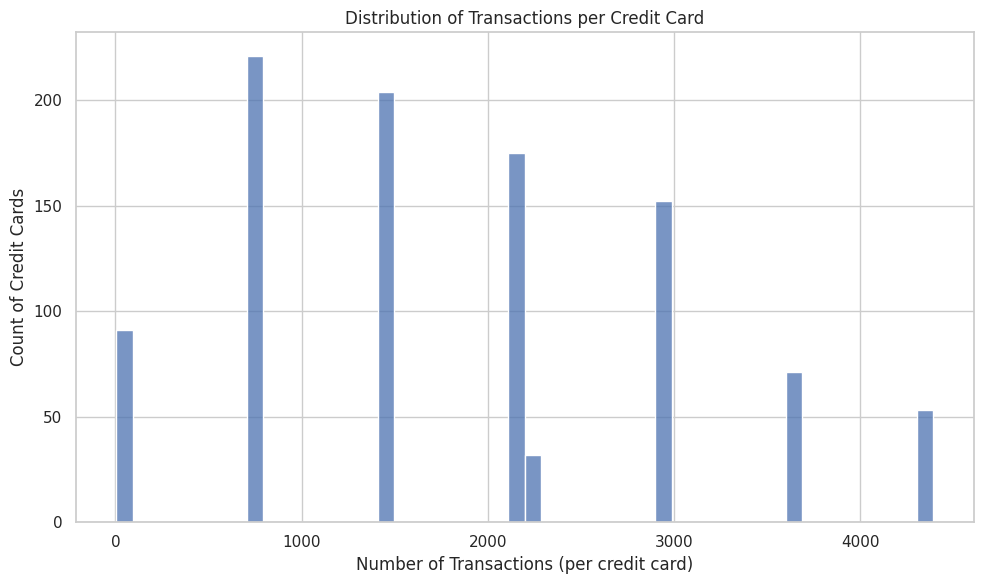

Mean transactions per card: 1854.25
Median transactions per card: 1471.00
Max transactions: 4392
Min transactions: 6


/tmp/ipykernel_3335994/298231469.py:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_trans_count.index.astype(str), y=top_trans_count.values, palette="viridis")


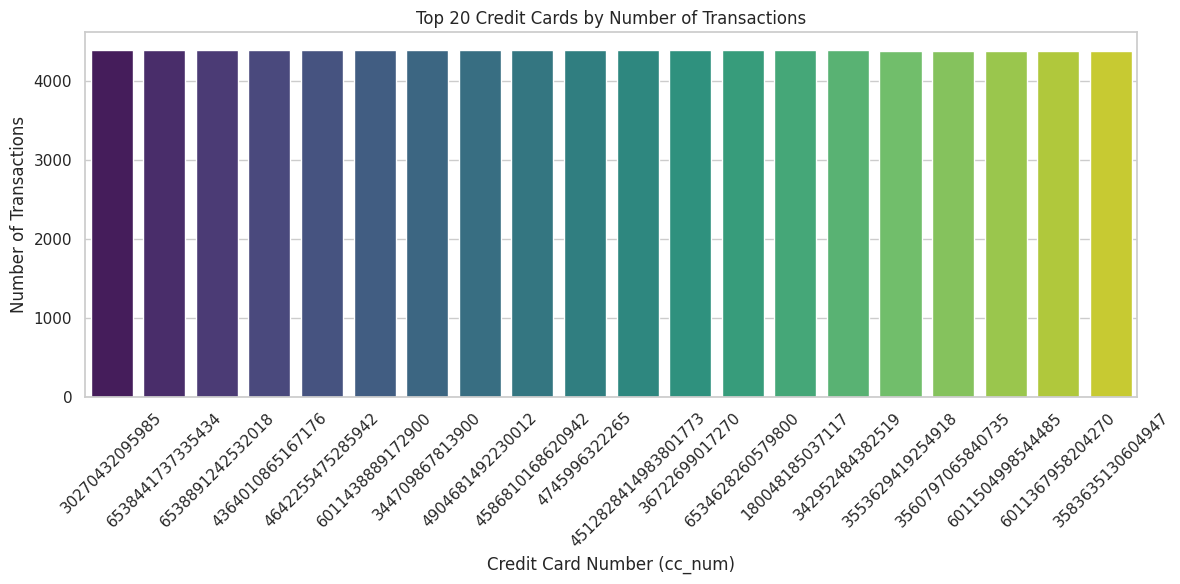

Max transactions (within top 20): 4392
Min transactions (within top 20): 4380


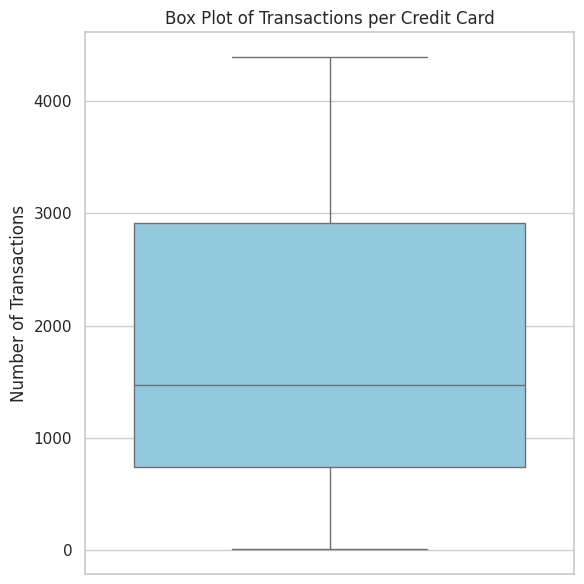


=== Fraud Analysis ===
Fraud transactions by day:
 day_of_week
Monday      NaN
Tuesday     NaN
Wednesday   NaN
Thursday    NaN
Friday      NaN
Saturday    NaN
Sunday      NaN
Name: count, dtype: float64

Fraud transactions by hour:
 hour
0      823
1      827
2      793
3      803
4       61
5       80
6       54
7       72
8       59
9       61
10      52
11      59
12      84
13      94
14     100
15     100
16      97
17      94
18     111
19     105
20      98
21     101
22    2481
23    2442
Name: count, dtype: int64


/tmp/ipykernel_3335994/298231469.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_day_count.index, y=fraud_day_count.values, palette="viridis")


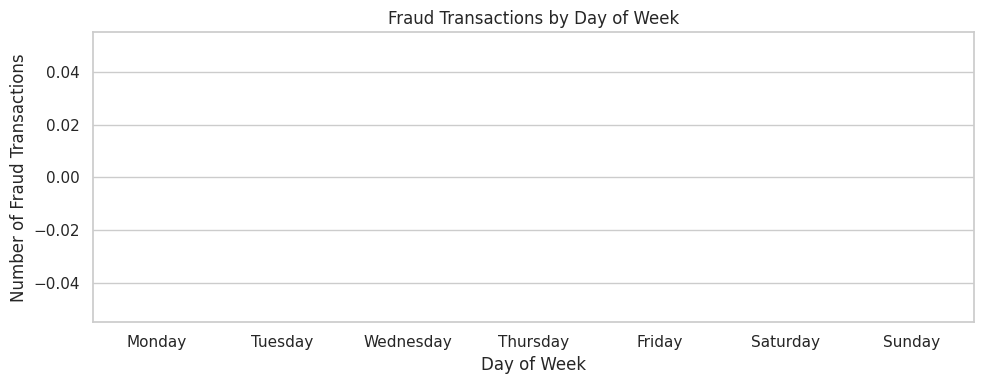

/tmp/ipykernel_3335994/298231469.py:158: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_hour_count.index, y=fraud_hour_count.values, palette="magma")


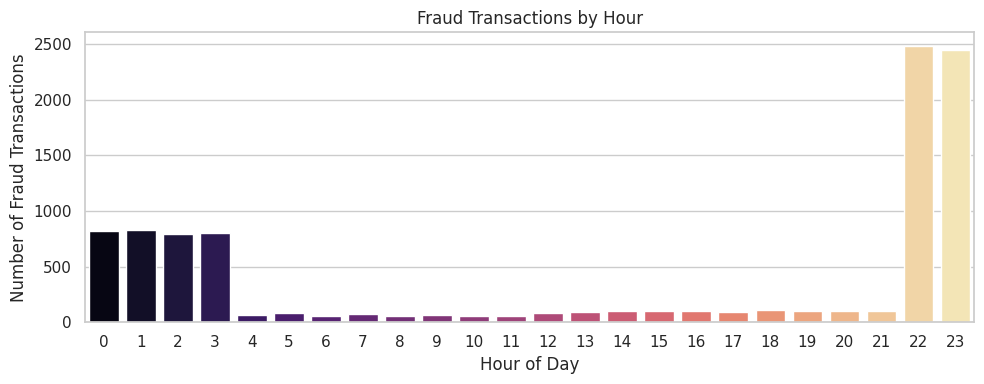

Unique cc_num with fraud transactions: 976 (97.70% of all cc_num)
Number of fraud transactions: 9651 (0.52% of all transactions)


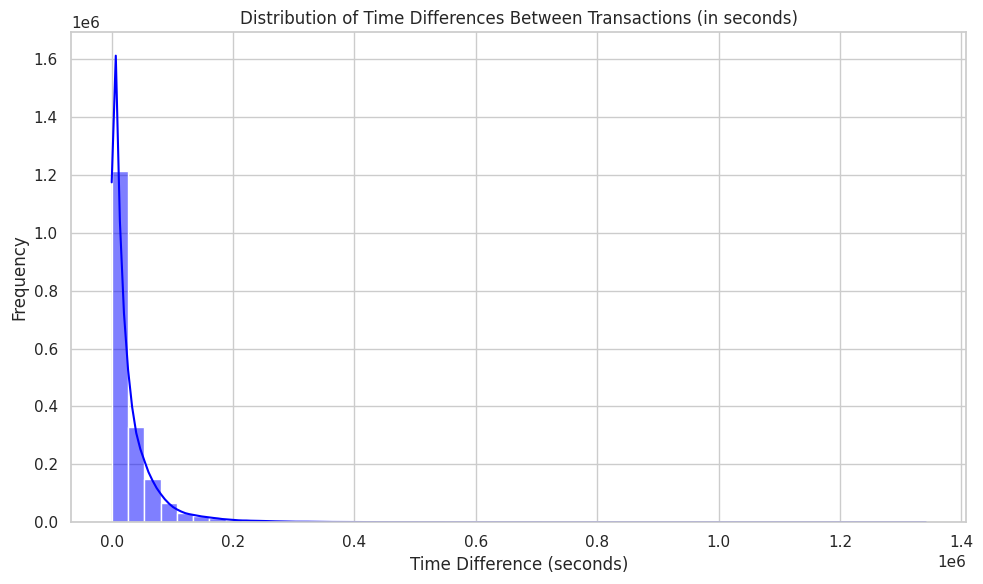

Percentage of fraud transactions with short time difference (<= 3600 seconds): 44.39%
Percentage of fraud transactions with long time difference (> 3600 seconds): 55.61%
Tổng số giao dịch gian lận: 9651
Số giao dịch gian lận xảy ra vào ban đêm (is_night == 1): 8169
Phần trăm giao dịch gian lận xảy ra vào ban đêm: 84.64%


/tmp/ipykernel_3335994/298231469.py:256: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette='coolwarm')


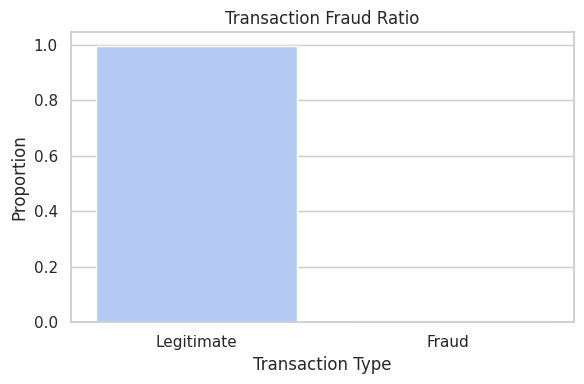

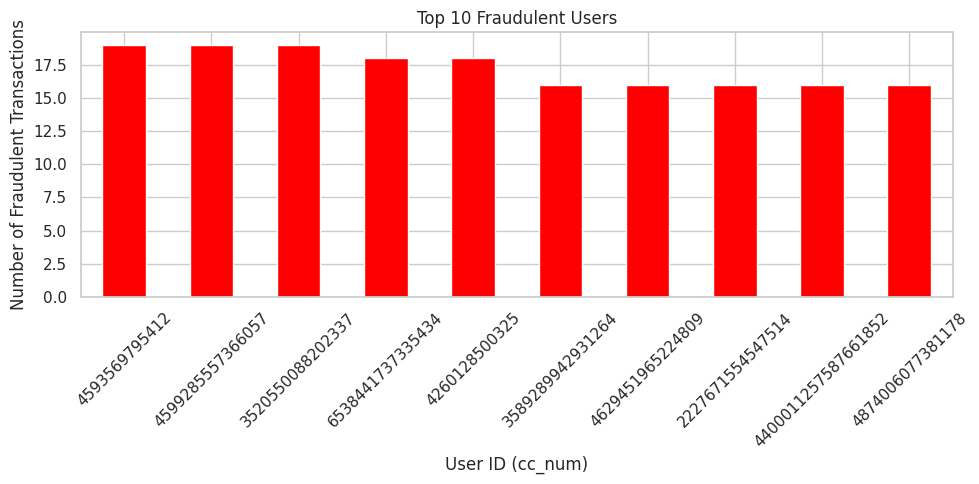

Total users with at least one fraud transaction: 976


/tmp/ipykernel_3335994/298231469.py:286: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_fraud', y='amt', data=df, palette="coolwarm")


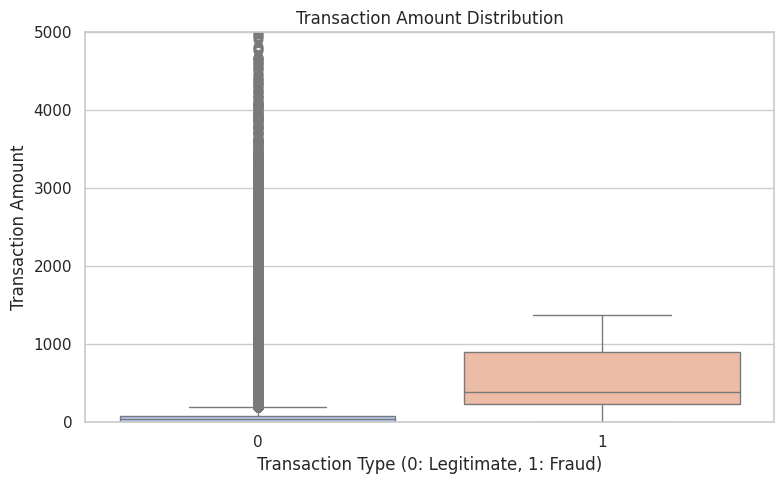

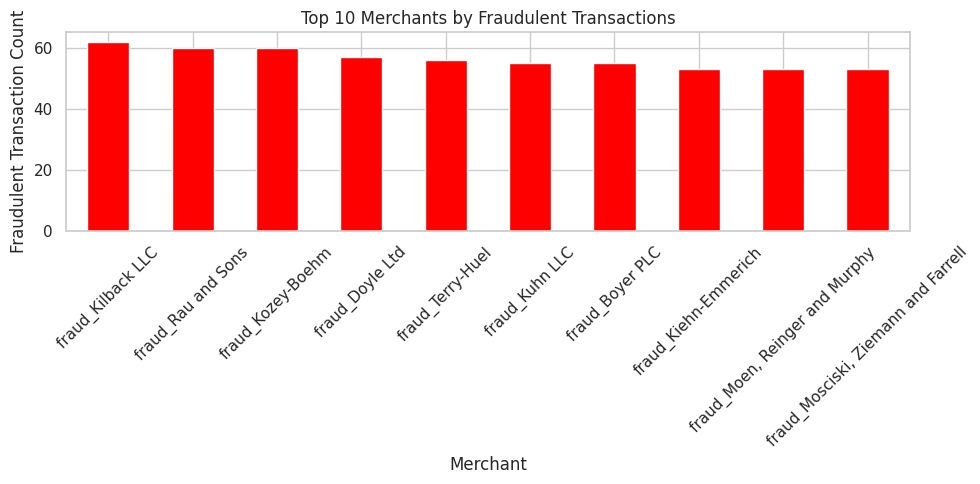

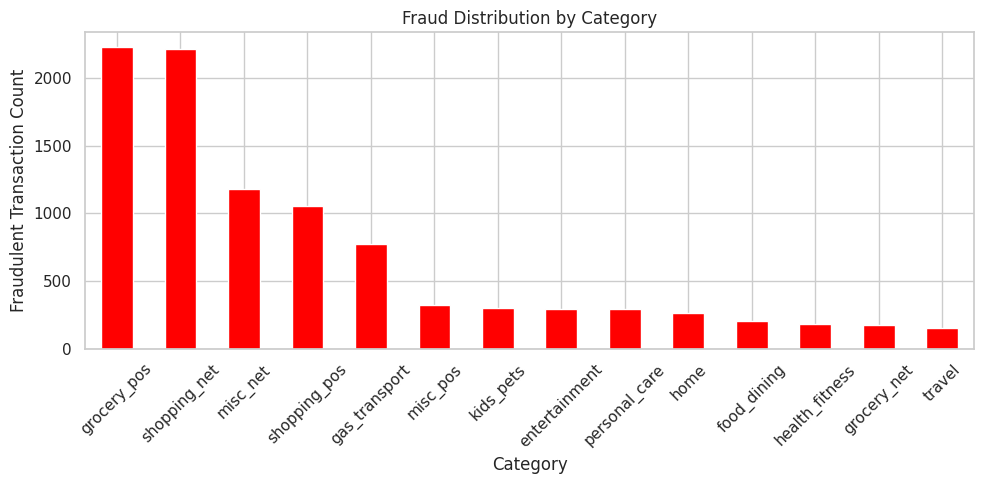

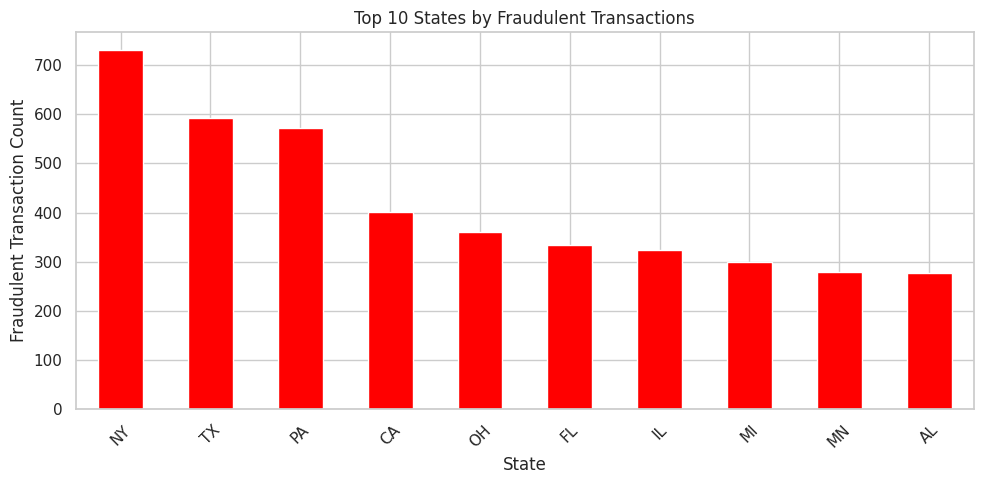

Top 10 Ages with the Most Fraudulent Transactions:
age
53    25
38    24
39    23
64    22
63    22
35    21
49    21
59    21
58    21
57    20
Name: cc_num, dtype: int64

Top 10 Ages with the Least Fraudulent Transactions:
age
20     1
100    1
23     1
101    1
22     2
87     3
21     3
92     3
95     3
24     4
Name: cc_num, dtype: int64


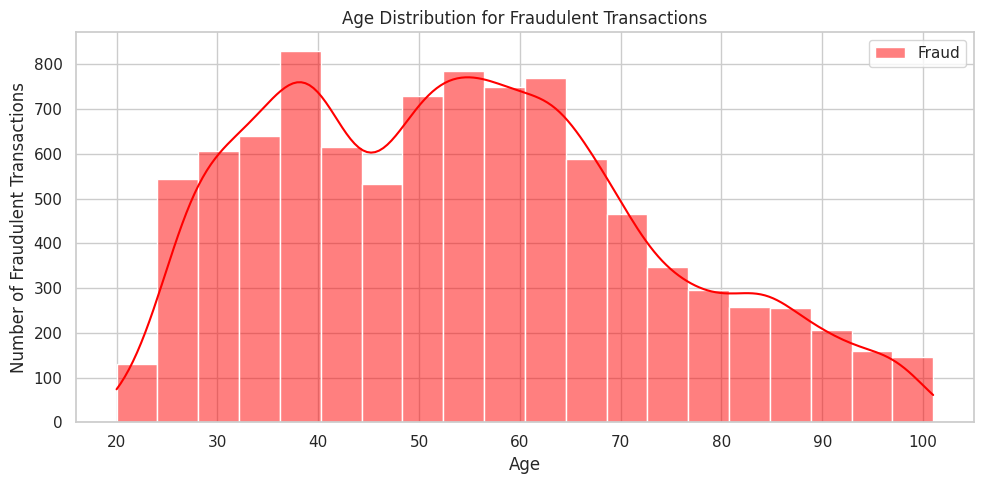


=== Fraud Clustering using K-Means ===


/tmp/ipykernel_3335994/298231469.py:401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraud_df['cluster'] = kmeans.fit_predict(scaled_features)


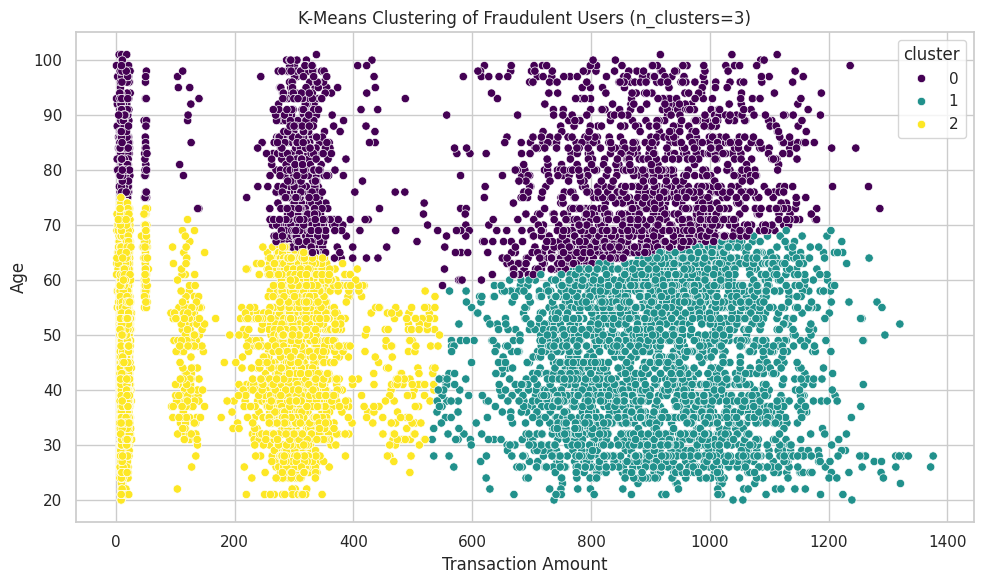


=== Fraud Clustering using DBSCAN ===


/tmp/ipykernel_3335994/298231469.py:422: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraud_df['dbscan_cluster'] = dbscan.fit_predict(scaled_features)


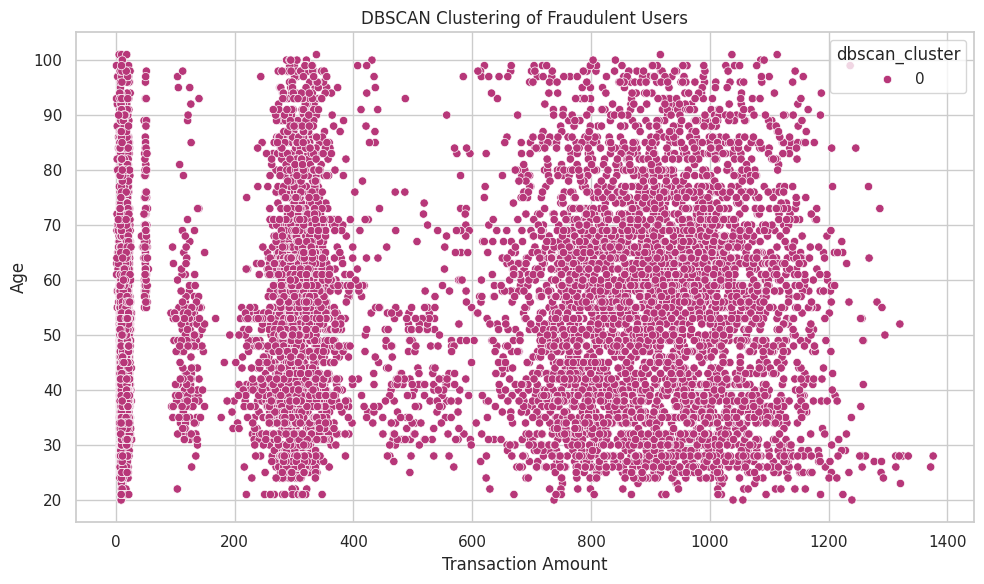


=== Fraud Anomaly Detection ===


/tmp/ipykernel_3335994/298231469.py:443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraud_df['anomaly'] = iso_forest.fit_predict(scaled_features)


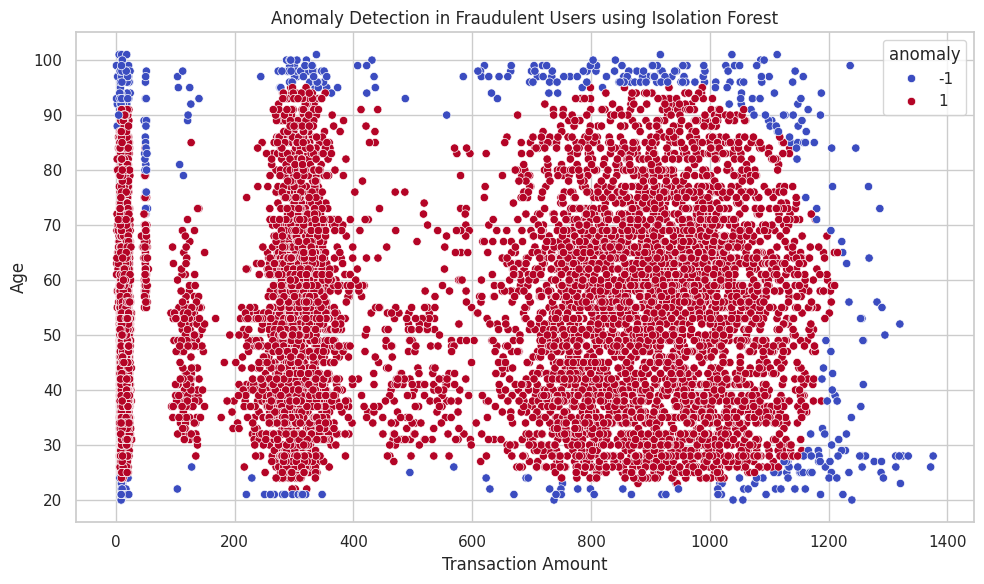

Number of anomalous fraudulent users detected: 483
Columns with missing values:
 Series([], dtype: int64)


In [9]:
def main():
    # Define the file path for the combined dataset
    file_path = '/home/ducanh/Financial Risk & Fraud Detection/Credit Card Fraud Detection/Datasets/CCFD/Combined_Data/combined_data.csv'
    
    # Load and preprocess data
    df = load_data(file_path)
    df = preprocess_data(df)
    print("=== Dataset Summary ===")
    dataset_summary(df)

    print("\n=== Transaction Analysis ===")
    transaction_analysis(df)
    transaction_analysis_histogram(df)
    transaction_analysis_top_n(df)
    transaction_analysis_boxplot(df)

    print("\n=== Fraud Analysis ===")
    fraud_analysis(df)
    # Calculate delta T (time differences)
    df = calculate_time_differences(df)

# Plot the distribution of time differences for all users
    plot_transaction_time_distribution(df)

# Plot the time differences per user (cc_num)
    fraud_time_distance_analysis(df, threshold=3600)
    fraud_night_analysis(df)
    plot_transaction_time_distribution
    overall_fraud_distribution(df)
    top_fraudulent_users(df)
    boxplot_transaction_amount(df)
    fraud_by_merchant_and_category(df)
    fraud_by_state(df)
    age_distribution(df)
    
        # --- Phân cụm và phát hiện bất thường --- #
    print("\n=== Fraud Clustering using K-Means ===")
    fraud_clustering_kmeans(df, n_clusters=3)
    
    print("\n=== Fraud Clustering using DBSCAN ===")
    fraud_clustering_dbscan(df)
    
    print("\n=== Fraud Anomaly Detection ===")
    fraud_anomaly_detection(df)
    
    # Save fraudulent transactions to CSV
    # df[df['is_fraud'] == 1].to_csv(
    #     '/home/ducanh/Credit Card Transactions Fraud Detection/EDA/fraud_transactions.csv', index=False)
    
    # Print columns with missing values
    missing_values = df.isnull().sum()
    print("Columns with missing values:\n", missing_values[missing_values > 0])
    
    # Generate and return the fraud map
    fraud_map = fraud_map_visualization(df)
    return fraud_map

# Execute the main function and display the map in the notebook
fraud_map = main()
fraud_map